In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

import pickle
import shutil
import sys
import time

# NumPy and TensorFlow
import numpy as np
import pandas as pd
import tensorflow as tf


import nltk
nltk.download("punkt")

sys.path.append("..")
# from features import common
from IPython.display import Image, HTML

[nltk_data] Downloading package punkt to /Users/koza/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
print "Loading dataset..."
with open("/Users/koza/Documents/UCBerkeley/266/FinalProject/w266_Project/data/ka-comments-balanced.pickle", "rb") as f:
    comments_dataset = pickle.load(f)    
print "Done."

Loading dataset...
Done.


In [3]:
comments_dataset.keys()

['test_data', 'validate_data', 'train_data']

In [4]:
# How many words in the longest post?
cont = comments_dataset['train_data']['content']
print max([len(x.split(" ")) for x in cont])
max_cont = comments_dataset['train_data'].iloc[max([len(x.split(" ")) for x in cont])]['content']

2999


In [10]:
test_data = comments_dataset['test_data']

In [5]:
# since the data was balanced in another notebook, we concatenate the train and eval set - 
# the TF implementation will split this set later. It's a little redundant, but less work than rewriting the TF implementaion.

# leave out comments_dataset['test_data'] for final evaluation
frames = [comments_dataset['train_data'], comments_dataset['validate_data']]
result = pd.concat(frames)

In [6]:
len(result[result['hasVotes'] != result['topRank']])

71778

In [7]:
# median number of votes
print result.sumVotesIncremented.median()

# pearson correlations
result.corr()

1.5


,answerCount,replyCount,sumVotesIncremented,hasVotes,daysAgo,totalComments,relRank,topRank,bottomRank,label
answerCount,1.000000,0.273661,0.423571,0.111714,-0.177366,0.020453,-0.112357,0.111036,-0.003214,0.111714
replyCount,0.273661,1.000000,0.361195,0.121518,-0.094213,0.011407,-0.119392,0.120900,-0.011339,0.121518
sumVotesIncremented,0.423571,0.361195,1.000000,0.202415,-0.267378,-0.012939,-0.220618,0.208624,-0.025852,0.202415
hasVotes,0.111714,0.121518,0.202415,1.000000,-0.643202,-0.008782,-0.678738,0.718167,-0.122125,1.000000
daysAgo,-0.177366,-0.094213,-0.267378,-0.643202,1.000000,-0.015273,0.427103,-0.450408,0.071562,-0.643202
totalComments,0.020453,0.011407,-0.012939,-0.008782,-0.015273,1.000000,-0.223145,0.138561,-0.079520,-0.008782
relRank,-0.112357,-0.119392,-0.220618,-0.678738,0.427103,-0.223145,1.000000,-0.754226,0.404523,-0.678738
topRank,0.111036,0.120900,0.208624,0.718167,-0.450408,0.138561,-0.754226,1.000000,-0.111441,0.718167
bottomRank,-0.003214,-0.011339,-0.025852,-0.122125,0.071562,-0.079520,0.404523,-0.111441,1.000000,-0.122125
label,0.111714,0.121518,0.202415,1.000000,-0.643202,-0.008782,-0.678738,0.718167,-0.122125,1.000000


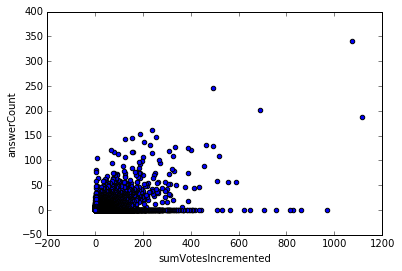

In [8]:
result.plot(kind='scatter', x='sumVotesIncremented', y='answerCount')

In [9]:
# this was taking forever..
# result.plot(kind='bar', x='authorKaid', y='sumVotesIncremented')

In [9]:
median = result.sumVotesIncremented.median()

# Prepare data to concatenate questions and answers

In [68]:
replies = result[result['replyTo'].notnull()]
questions = result[result['replyTo'].isnull()]

In [65]:
replies = replies[['video','id','replyTo','label','content']]
questions = questions[['video','id','replyTo','label','content']]
questions.head()

,video,id,replyTo,label,content
0,adding-and-subtracting-the-same-thing-from-bot...,baf97918adcfa541a668b8141c932adadbdb63b2,NaN,True,I have a great 'why' question. Why is there a...
1834,the-beauty-of-algebra,b6a0a3eec44cf791bf8dc64f75278f293911ee72,NaN,False,How do I do fractions?
1025,the-beauty-of-algebra,03ae91f219a5ff2df4646bd7c9b6247896b0e7fe,NaN,True,Why is learning alegbra so important?
1835,the-beauty-of-algebra,99504c27f0bfdc90b095a836a3a0266e18e9ceab,NaN,False,Why is the history of algebra important?
1836,the-beauty-of-algebra,e8ade3a31cf42a329470de8ff40e1d1be10c8166,NaN,False,""" for any positive integer n,n! denotes the pr..."


In [69]:
merged = pd.merge(replies, questions, how='inner', left_on='replyTo', right_on='id',
         left_index=False, right_index=False, sort=True,
         suffixes=('_r', '_q'), copy=True, indicator=False)

In [76]:
for col in merged.columns:
  print col

video_r
content_q
content_r
hasVotes_r


In [71]:
merged = merged[['video_r','content_q','content_r','hasVotes_r']]
merged.head()

,video_r,content_q,content_r,hasVotes_r
0,evaluating-a-function-expression,"At 1:09, Is -2*7+-5 consiered to be equal to -...",yeah it is true,False
1,evaluating-a-function-expression,"At 1:09, Is -2*7+-5 consiered to be equal to -...","YES! since f(-6) = 7 and since g(1) = -5, then...",True
2,a-tour-through-ancient-rome-in-320-c-e,what exactly is the forum? and what is the Pan...,Forum Romanum (https://www.khanacademy.org/hum...,True
3,ss-searching-for-scholarships,any suggestions for single parentsup to trying...,yes. you should probably find courses on the w...,True
4,introduction-to-square-roots,is it Principle not Principal?,I think principal root comes from the second d...,True


## Make a sample dataset for hand scoring

In [74]:
sample = merged.sample(n=500)
sample.to_csv("../data/500sample.csv")

## Concatenate questions and answers

In [40]:
merged['content'] = merged["content_q"].map(str) + " " + merged["content_r"]
merged = merged[['label_r','content']]

merged.head()


,label_r,content
0,0,what would you do if you raises a power to a p...
1,0,How do we find the basis of ker(T) when ker(T)...
2,0,"At 1:09, Is -2*7+-5 consiered to be equal to -..."
3,0,"At 1:09, Is -2*7+-5 consiered to be equal to -..."
4,0,if you use the tangent to find the slope of a ...


## For the TensorFlow CNN

In [45]:
# make positive and negative data sets
pos_data_train = result.loc[result['hasVotes'] == 1]
pos_data_train = pos_data_train[pos_data_train['replyTo'].notnull()]

neg_data_train = result.loc[result['hasVotes'] == 0]
neg_data_train = neg_data_train[neg_data_train['replyTo'].notnull()]

# If using concatenated questions and answers
# pos_data_train = merged.loc[merged['label_r'] == 1]
# neg_data_train = merged.loc[merged['label_r'] == 0]


print len(neg_data_train)
print len(pos_data_train)

117641
157242


In [11]:
pos_data_test = test_data.loc[test_data['hasVotes'] == 1]
pos_data_test = pos_data_test[pos_data_test['replyTo'].notnull()]

neg_data_test = test_data.loc[test_data['hasVotes'] == 0]
neg_data_test = neg_data_test[neg_data_test['replyTo'].notnull()]

In [73]:
## THERE ARE SOME VERY LONG stupid responses which make the max document length really big, and explode the id matrix. 

In [13]:
longest_entry = max([x.split(' ') for x in neg_data_test['content']], key=len)
len(longest_entry)

602

In [47]:
print len(max([x.split(' ') for x in neg_data_train['content']], key=len))
print len(max([x.split(' ') for x in pos_data_train['content']], key=len))

1620
2716


In [27]:
## limit the replies to N words. This removes entries like 100K swastika symbols.
N = 1000
P = 3000
neg_data_train = neg_data_train[[(len(x.split(' ')) < N) for x in neg_data_train['content']]]
pos_data_train = pos_data_train[[(len(x.split(' ')) < P) for x in pos_data_train['content']]]

print len(max([x.split(' ') for x in neg_data_train['content']], key=len))
print len(max([x.split(' ') for x in pos_data_train['content']], key=len))
" ".join(max([x.split(' ') for x in neg_data_train['content']], key=len))

1362
1670


'Let\'s start with tan. The domain of tan is all reals except pi/2 + pi(k) because one way to view tan is, it is the slope of the line that forms an angle (e.g. theta) with the non-negative part of the x-axis in the unit circle. If theta = pi/2 (90 degrees), then that line will be pointing upward, so the slope will be undefined. I want to make it clear: that slope will be *undefined*, it won\'t be 0 or anything else. A slope of 0 would be a line along the x-axis. Remember that slope = rise/run, or put another way, change in y over change in x. If the line is pointing upward, then what would be your change in y? This is kind of an awkward question to answer, but that doesn\'t even matter; what matters is that if you take any two points on that line, the change in x will be... 0! The x value never changes. So, since slope = change in y over change in x, and that change in x = 0, then finding the slope of that line would be equivalent to dividing by 0, hence the slope is undefined, just a

In [ ]:
pos_data_train.to_csv('/Users/koza/Documents/UCBerkeley/266/FinalProject/w266_Project/cnn-text-classification-tf/data/pos_data_train',
                      columns=['content'],
                      index=False)


neg_data_train.to_csv('/Users/koza/Documents/UCBerkeley/266/FinalProject/w266_Project/cnn-text-classification-tf/data/neg_data_train',
                      columns=['content'],
                      index=False)

In [ ]:
pos_data_test.to_csv('/Users/koza/Documents/UCBerkeley/266/FinalProject/w266_Project/cnn-text-classification-tf/data/pos_data_test',
                      columns=['content'],
                      index=False)


neg_data_test.to_csv('/Users/koza/Documents/UCBerkeley/266/FinalProject/w266_Project/cnn-text-classification-tf/data/neg_data_test',
                      columns=['content'],
                      index=False)

In [17]:
len(neg_data_test)

1204

python eval.py --eval_train true --positive_data_file data/pos_data_test --negative_data_file data/neg_data_test --checkpoint_dir /Users/koza/Documents/UCBerkeley/266/FinalProject/w266_Project/cnn-text-classification-tf/runs/1481637188/checkpoints

# Results
### The best CNN model produced 63.5% accuracy on the dev set, with the following parameters:
<pre>
python train.py 
    --positive_data_file data/pos_data_train 
    --negative_data_file data/neg_data_train 
    --dev_sample_percentage .005

-----------------------------
Parameters:
-----------------------------
ALLOW_SOFT_PLACEMENT=True
BATCH_SIZE=64
CHECKPOINT_EVERY=100
DEV_SAMPLE_PERCENTAGE=0.005
DROPOUT_KEEP_PROB=0.5
EMBEDDING_DIM=128
EVALUATE_EVERY=100
FILTER_SIZES=3,4,5
L2_REG_LAMBDA=0.0
LOG_DEVICE_PLACEMENT=False
NEGATIVE_DATA_FILE=data/neg_data_train
NUM_EPOCHS=200
NUM_FILTERS=128
POSITIVE_DATA_FILE=data/pos_data_train

Loading data...
('l-positive_examples', 157242)
('l-negative_examples', 117641)

Build vocabulary...
('max_document_length...', 2716)
('x shape', (274883, 2716))

Split train/test set...
Vocabulary Size: 161304
Train/Dev split: 273509/1374

Writing to /Users/koza/Documents/UCBerkeley/266/FinalProject/w266_Project/cnn-text-classification-tf/runs/1481637188
</pre>

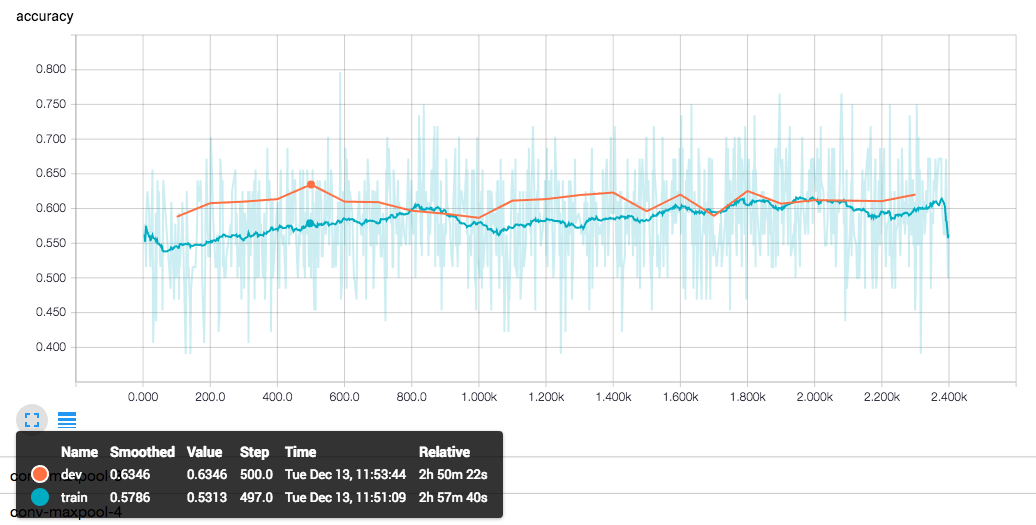

In [89]:
Image('../CNN-results/best-CNN-accuracy.png')

# The CNN Graph:

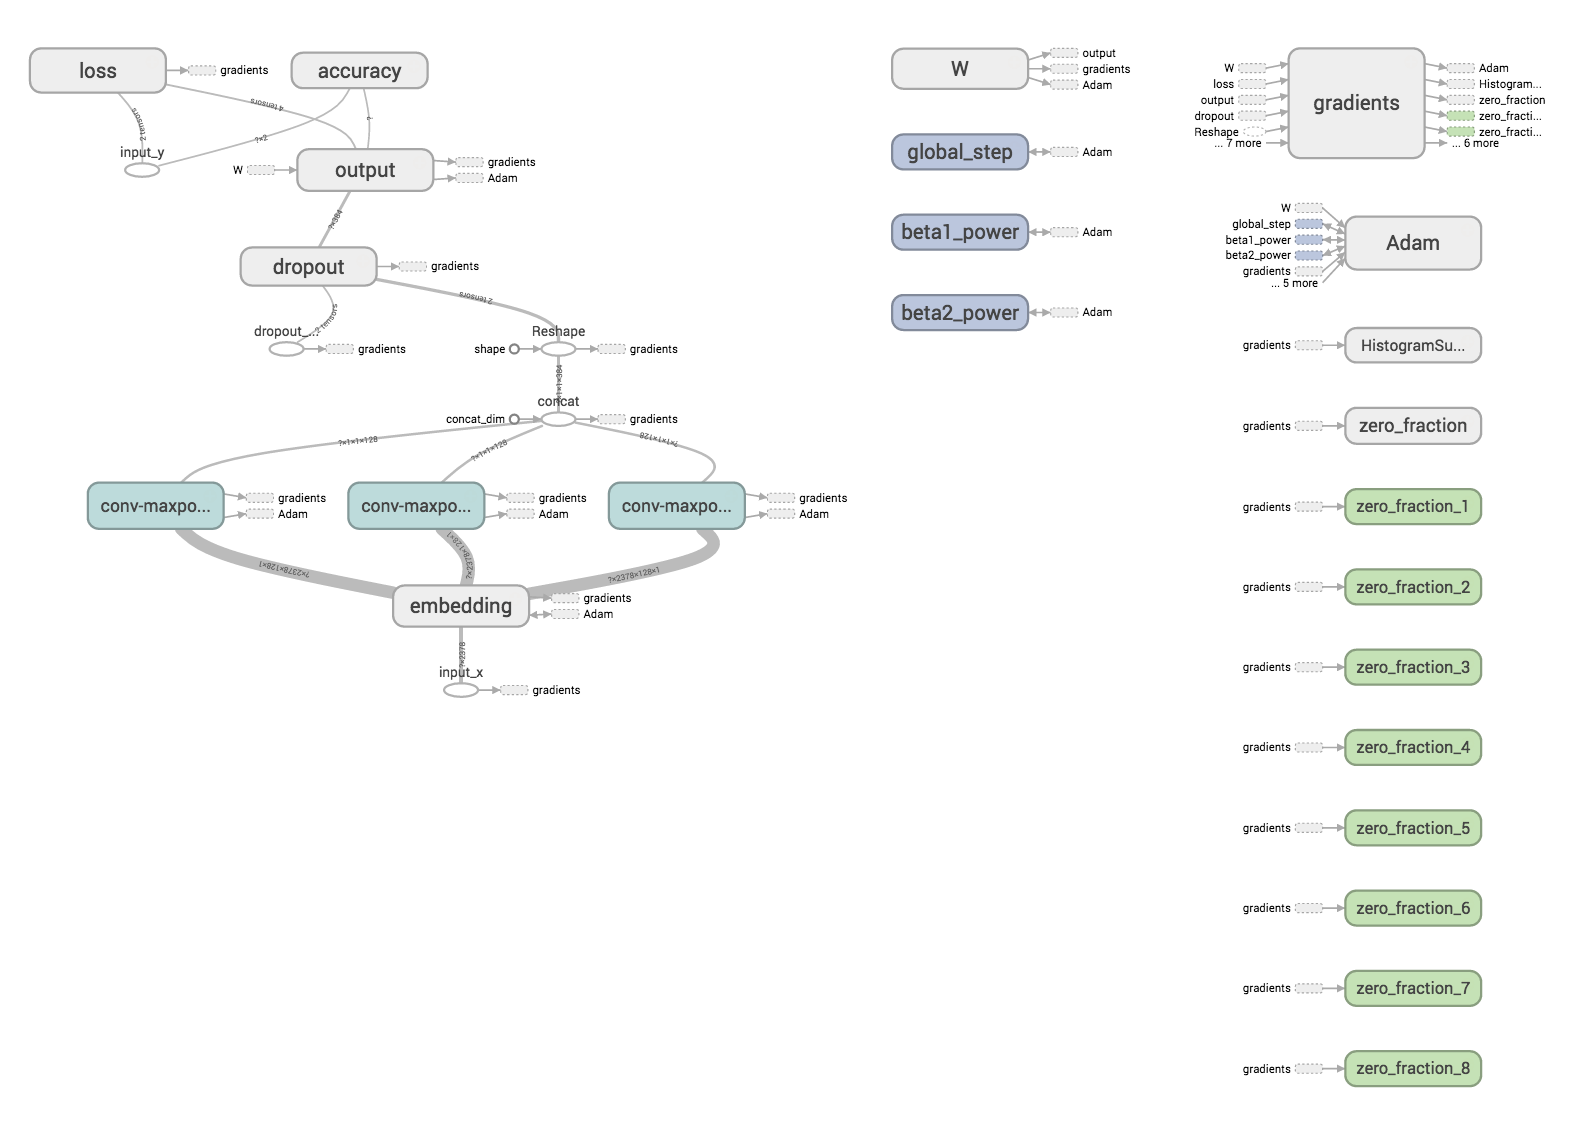

In [90]:
Image('../CNN-results/graph.png')

## Test Runs (mini dataset)
The model was able to (mostly) memorize the tiny dataset:

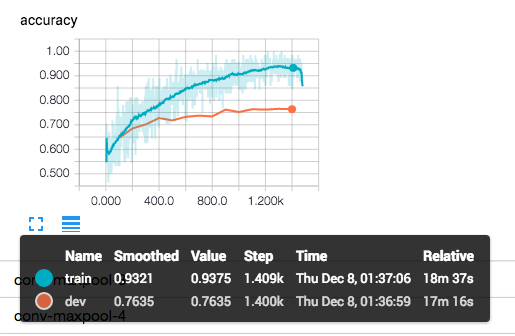

In [5]:
Image('../images/CNN-using small dataset.png')

# Sources:
Theano and TensorFlow implementations used as boilerplate:

### Theano
http://arxiv.org/abs/1508.04112   
https://github.com/taolei87/text_convnet   

### TensorFlow
https://arxiv.org/pdf/1510.03820v4.pdf   
https://arxiv.org/pdf/1408.5882v2.pdf   
https://github.com/dennybritz/cnn-text-classification-tf   
http://www.wildml.com/2015/12/implementing-a-cnn-for-text-classification-in-tensorflow/